**Домашнее задание к занятию «Классификация: Логистическая регрессия и SVM»**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adult = pd.read_csv('adult.csv', na_values='?')

In [3]:
adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Очевидны выбросы по параметрам capital-gain и capital-loss.

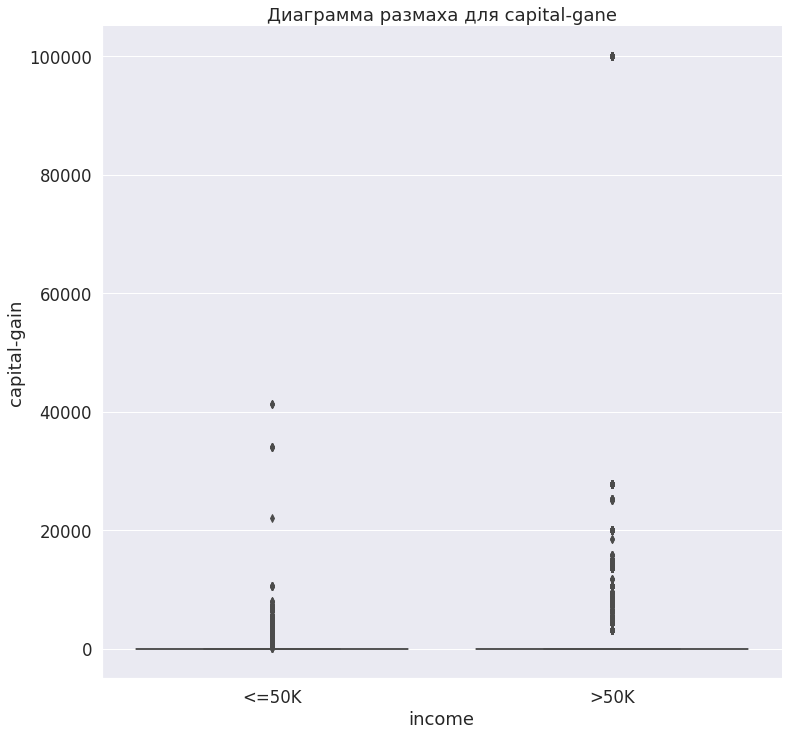

In [6]:
sns.set(font_scale = 1.5)
g = sns.catplot(x ='income',
                y ='capital-gain',
                kind='box',
                data = adult).set(title = 'Диаграмма размаха для capital-gane')

g.fig.set_figwidth(15)
g.fig.set_figheight(12)

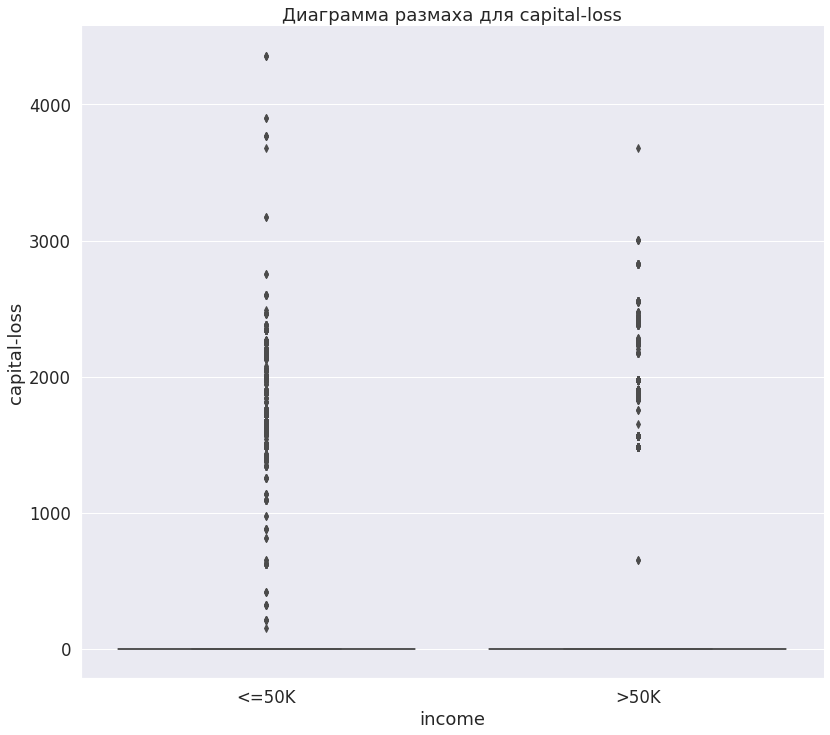

In [7]:
sns.set(font_scale = 1.5)
g = sns.catplot(x ='income',
                y ='capital-loss',
                kind='box',
                data = adult).set(title = 'Диаграмма размаха для capital-loss')

g.fig.set_figwidth(15)
g.fig.set_figheight(12)

У обоих параметров очень много нулевых значений.

In [8]:
adult['capital-gain'].value_counts()

0        44807
15024      513
7688       410
7298       364
99999      244
         ...  
1111         1
7262         1
22040        1
1639         1
2387         1
Name: capital-gain, Length: 123, dtype: int64

In [9]:
adult['capital-loss'].value_counts()

0       46560
1902      304
1977      253
1887      233
2415       72
        ...  
2465        1
2080        1
155         1
1911        1
2201        1
Name: capital-loss, Length: 99, dtype: int64

Посмотрим, как распределяются значения этих параметров у людей с высоким доходом

In [10]:
adult[adult['income'] == '>50K']['capital-gain'].value_counts()

0        9196
15024     513
7688      410
7298      364
99999     244
5178      146
3103      142
4386       92
8614       82
10520      64
27828      58
14084      49
20051      49
13550      42
4787       35
14344      34
9386       31
10605      19
6418       16
7430       15
25236      14
6514       10
4934       10
15020      10
15831       8
5556        6
25124       6
9562        5
4687        4
11678       4
7896        3
6097        2
18481       2
7262        1
6612        1
Name: capital-gain, dtype: int64

In [11]:
adult[adult['income'] == '>50K']['capital-loss'].value_counts()

0       10543
1902      286
1977      253
1887      233
2415       72
1848       67
1485       45
1564       43
2444       20
2559       17
2258       16
2824       14
2377       13
2392       11
2174       10
2246        8
2231        7
2547        5
3004        5
1825        5
2472        4
2282        2
653         2
1755        2
1911        1
1648        1
3683        1
2201        1
Name: capital-loss, dtype: int64

Нулевых значений гораздо меньше, значит эти признаки могут быть информативными.

Попробуем заполнить пустые значения в столбце 'workclass' на основе столбца 'occupation', если там они не пропущены.

In [12]:
adult[(adult['workclass'].isnull())&~(adult['occupation'].isnull())]

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income


Таких значений, нету, поэтому мы удаляем пустые значения. Как вариант, можно было бы заполнить пустые значения в столбцах workclass и occupation наиболее часто встречающимся значением.

In [13]:
adult = adult.dropna()
adult.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              45222 non-null  int64 
 1   workclass        45222 non-null  object
 2   fnlwgt           45222 non-null  int64 
 3   education        45222 non-null  object
 4   educational-num  45222 non-null  int64 
 5   marital-status   45222 non-null  object
 6   occupation       45222 non-null  object
 7   relationship     45222 non-null  object
 8   race             45222 non-null  object
 9   gender           45222 non-null  object
 10  capital-gain     45222 non-null  int64 
 11  capital-loss     45222 non-null  int64 
 12  hours-per-week   45222 non-null  int64 
 13  native-country   45222 non-null  object
 14  income           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


**Визуальное исследование данных**

Посмотрим на взяимосвязи признаков с помощью графиков

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

Напишем функцию для построения графика взаимосвязи количественных признаков и целевой переменной

In [15]:
def plot_catplot(x,y):
    '''Функция для визуализации распределения количественных признакоы по категориям'''
    sns.set(font_scale = 1.5)
    g = sns.catplot(x =x,
                y =y,
                data = adult).set(title=f'Распределение {x} по {y}')

    g.fig.set_figwidth(15)
    g.fig.set_figheight(12)

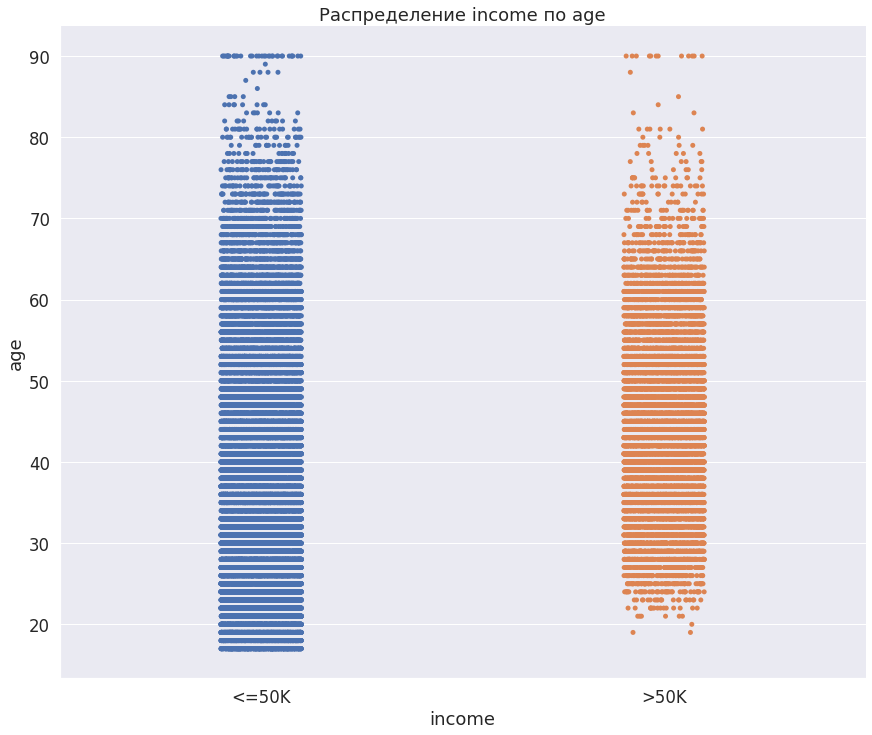

In [16]:
plot_catplot('income','age')

Тут прослеживается некоторая тенденция, что высокий доход встречается у людей с возрастом в диапазоне ~ от 25 до 65 лет, тем временем более низкий доход сильнее разбросан по возрасту. Это логично.

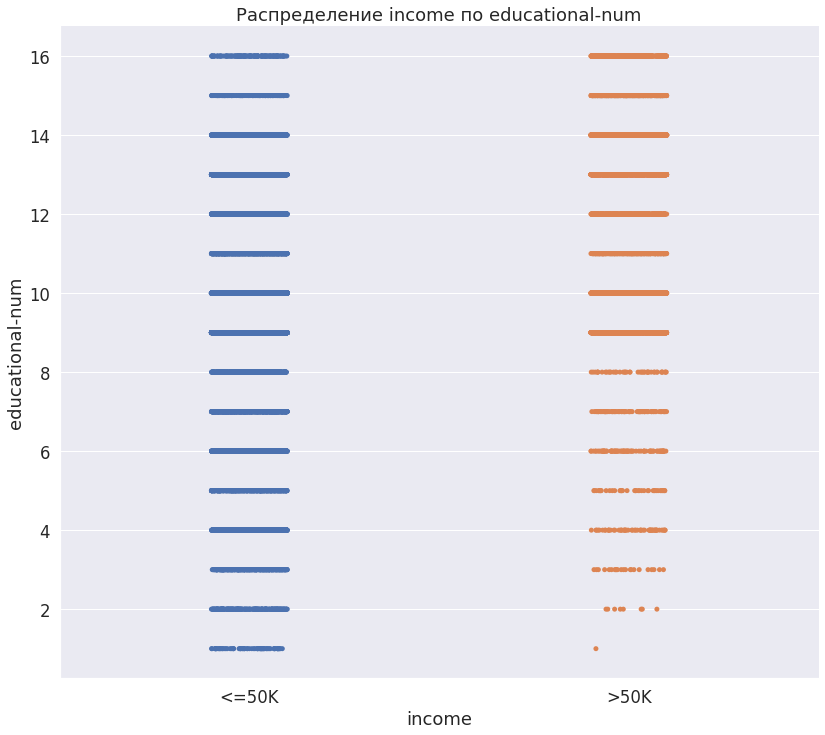

In [17]:
plot_catplot('income','educational-num')

Степень важности этого признака для целевой перемнной сложно уловить по графику. Наименьшее количество образовательных часов практически не наблюдается в группе с высоким доходом.

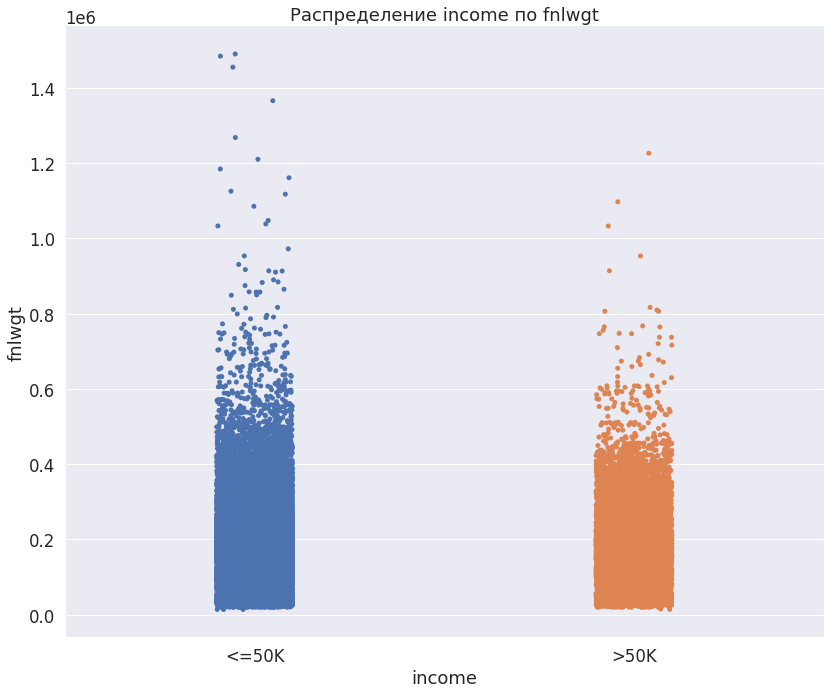

In [18]:
plot_catplot('income','fnlwgt')

Этот признак основан на статистике по данным, и неочевидно его значение для целевой переменной. По графику тоже не очень понятно. В дальнейшем попроброуем протестировать модели без него.

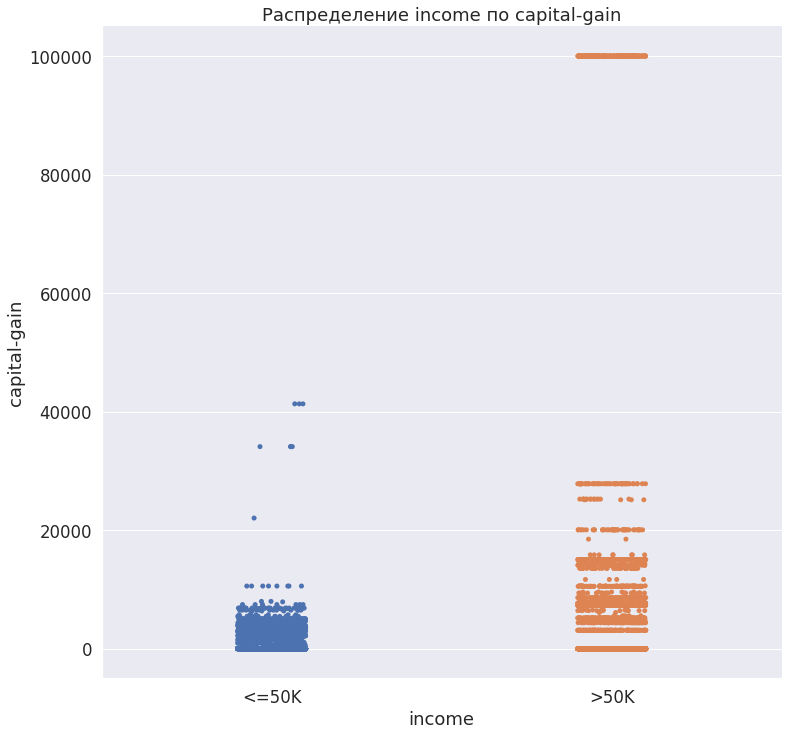

In [19]:
plot_catplot('income','capital-gain')

Тут есть аномалии, очевидно, что прирост дохода в 100000 предполагает доход >50K. По графику можно предположить, что люди с большим приростом имеют больший доход.

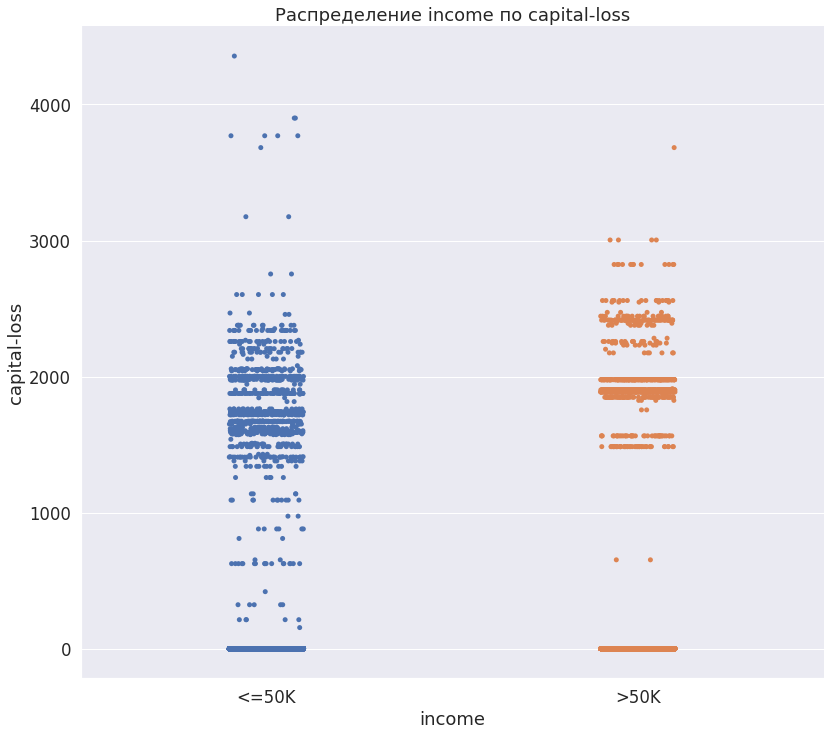

In [20]:
plot_catplot('income','capital-loss')

По этому графику интересно преположить, что люди, которые больше рискуют, больше зарабатывают, но это слишком неочевидное предположение.

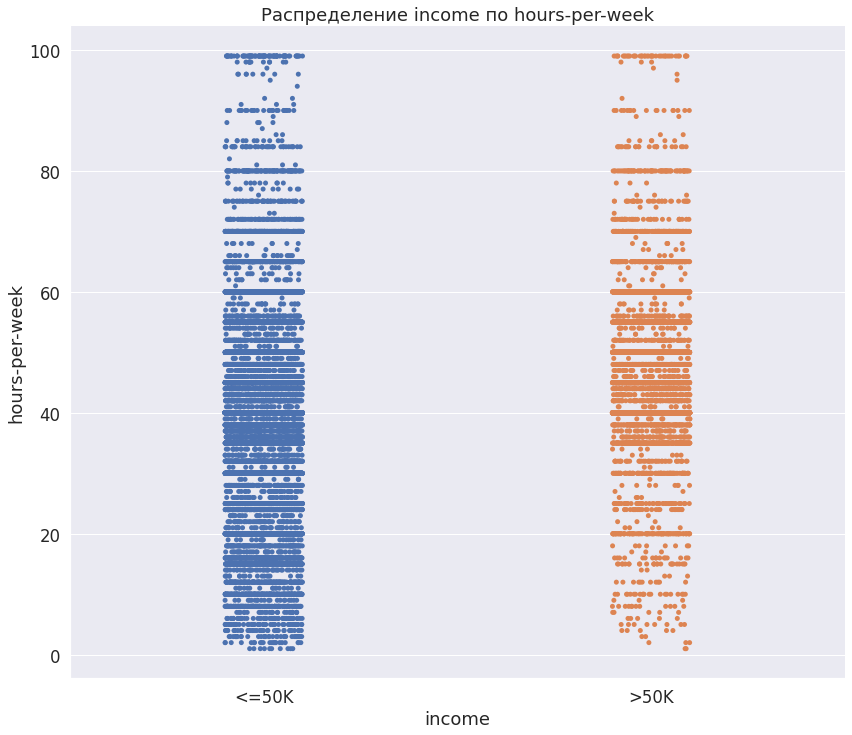

In [21]:
plot_catplot('income','hours-per-week')

По графику можно предположить, что люди, работающие меньшее количество времени в неделю, имеют меньший доход. Этот признак может влять на целевую переменную.

Построим график распределения income по по capital-gain в разрезе workclass и gender

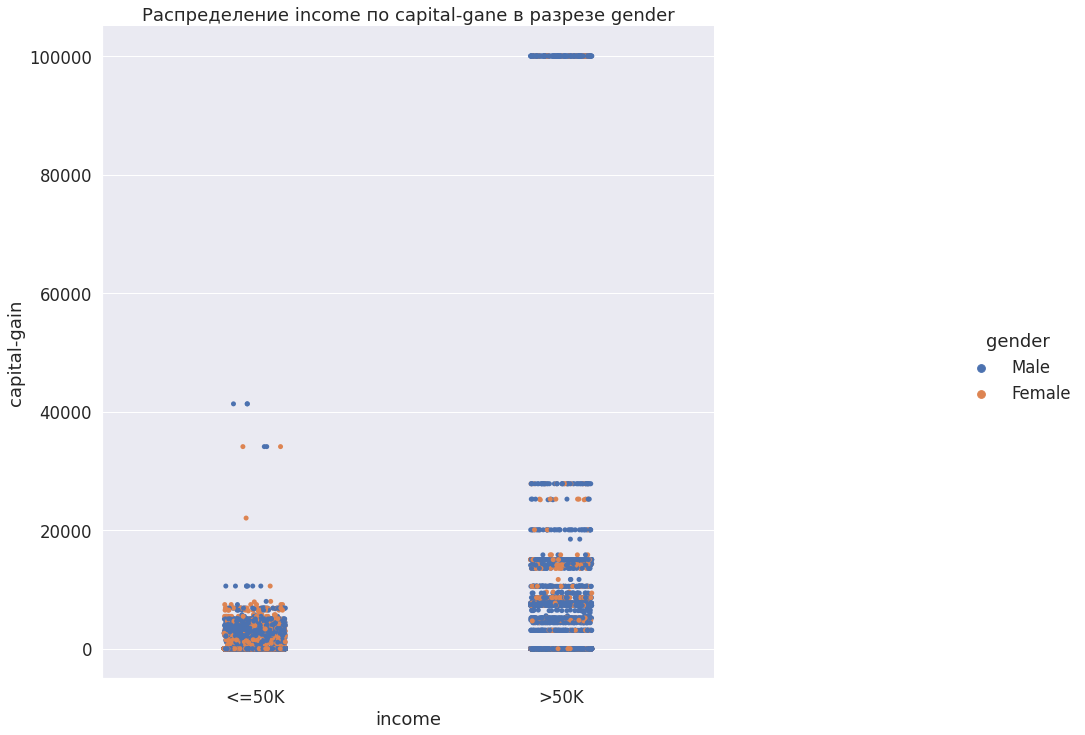

In [22]:
sns.set(font_scale = 1.5)
g = sns.catplot(x = 'income',
                y ='capital-gain',
                hue = 'gender',
                data = adult).set(title=f'Распределение income по capital-gane в разрезе gender')

g.fig.set_figwidth(20)
g.fig.set_figheight(12)

По данному графику можно предположить, что от пола зависит прирост дохода и доход в целом. Больше доход у мужчин.

Но это может быть связано еще с тем, в какой пропорции есть данные представителей полов.

<AxesSubplot:title={'center':'Количество людей в зависимости от пола'}, ylabel='gender'>

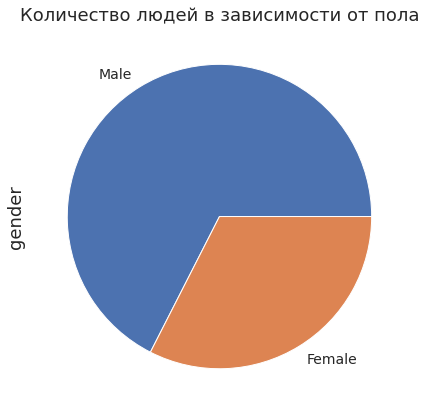

In [23]:
adults_by_workclass = adult['gender'].value_counts()
adults_by_workclass.plot(kind='pie', title='Количество людей в зависимости от пола', fontsize = 14)

Возможно, картина, наблюдаемая в предыдущем графике, связана с тем, что данных по женщинам приблизительно в три раза меньше, чем по мужчинам. Поэтому посмотрим на средние значения.

Text(0.5, 1.0, 'Прирост капитала в зависимости от пола')

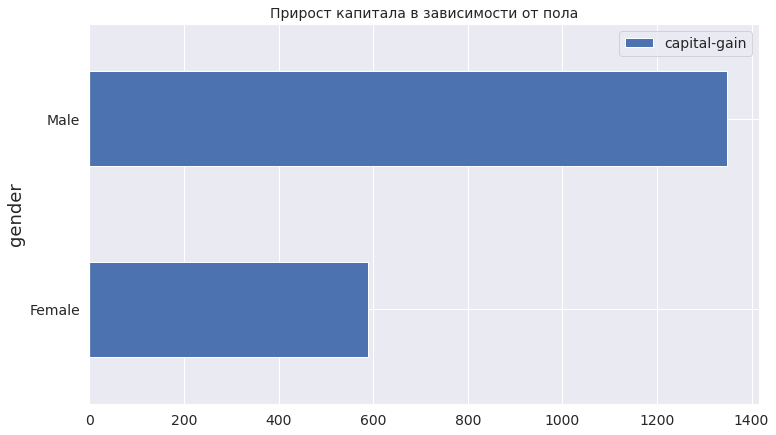

In [24]:
adult[['capital-gain','gender']].groupby('gender').mean().plot(kind='barh', fontsize = 14)
plt.legend(fontsize = 14)
plt.title('Прирост капитала в зависимости от пола', fontsize = 14)


Прирост капитала у мужчин больше, чем у женщин.

Посмотрим на разделение по роду деятельности

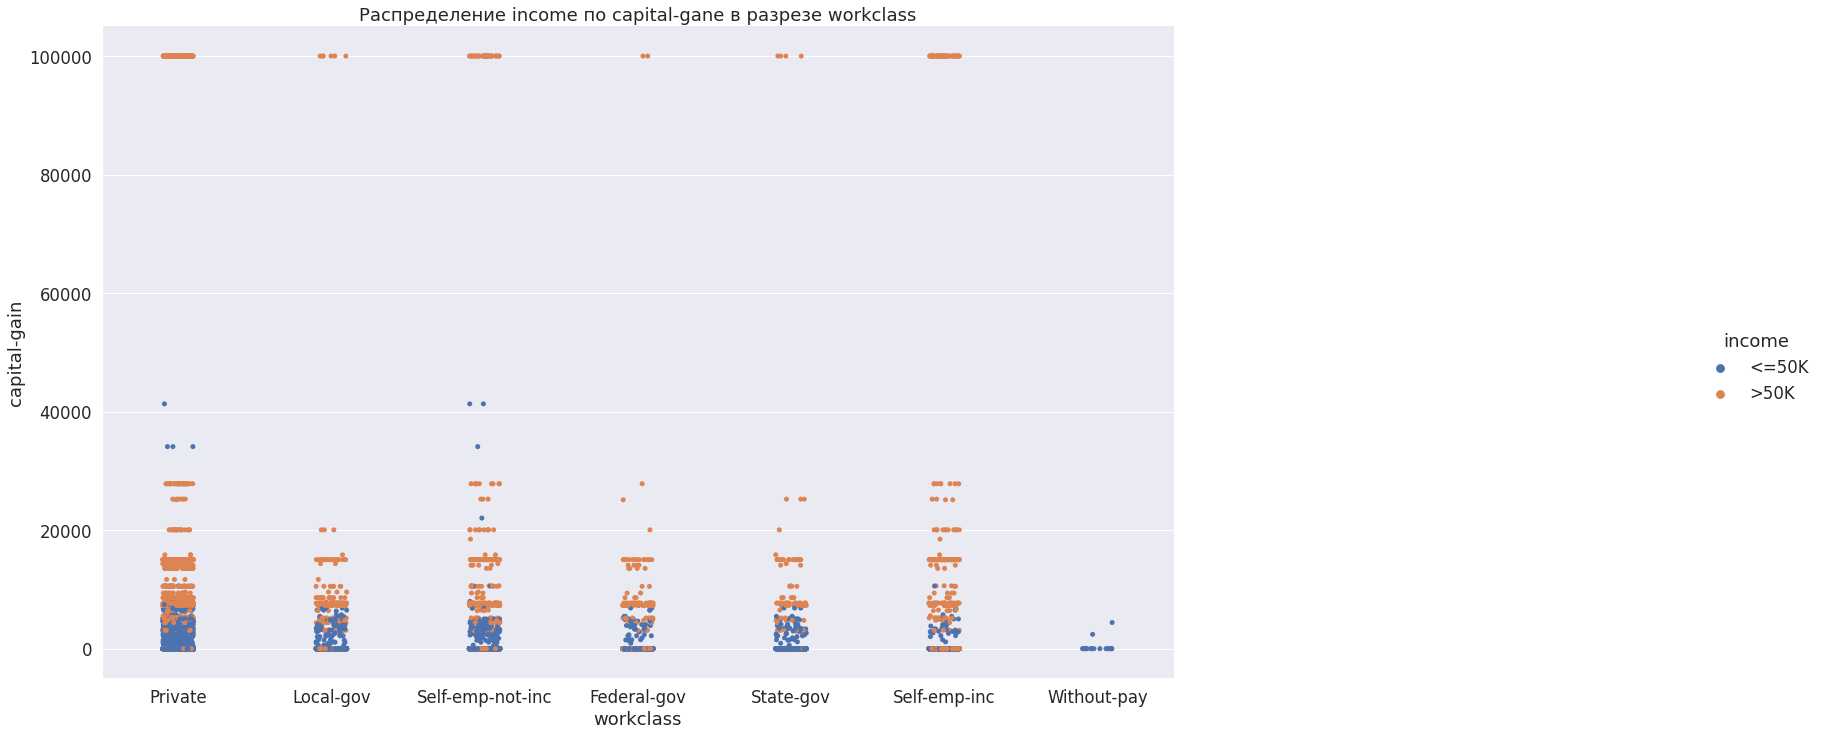

In [25]:
sns.set(font_scale = 1.5)
g = sns.catplot(x = 'workclass',
                y ='capital-gain',
                hue = 'income',
                data = adult).set(title=f'Распределение income по capital-gane в разрезе workclass')

g.fig.set_figwidth(35)
g.fig.set_figheight(12)

Признаки workclass и ocupation взаимосвязаны как множество и подмножество. Один из них можно не учитывать при построении модели, например, более общий.

Посмотрим, как распределяются данные по другим категориальным признакам

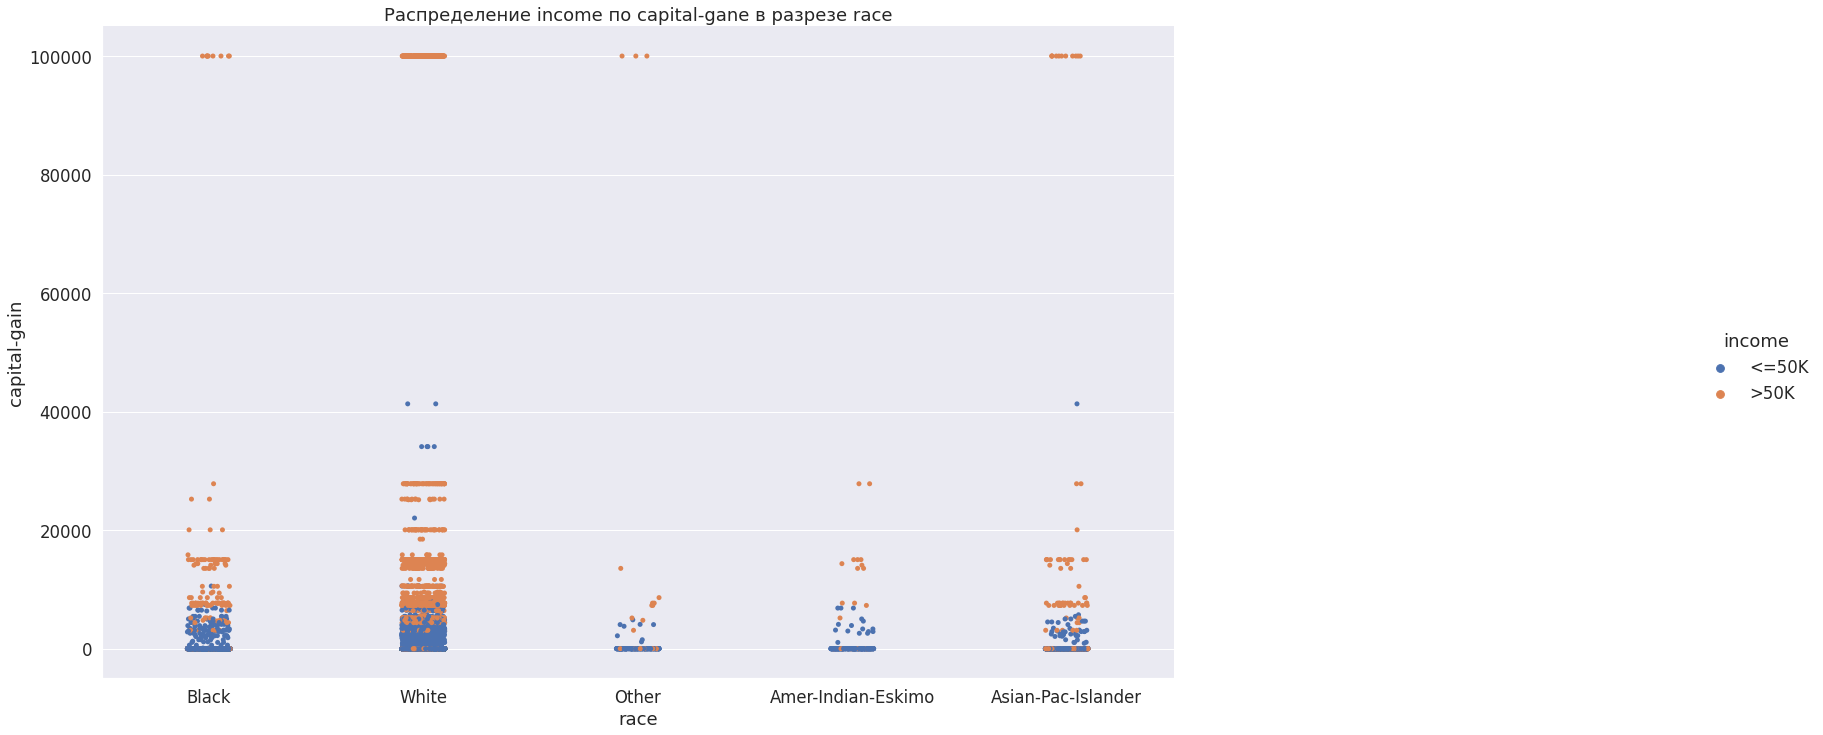

In [26]:
sns.set(font_scale = 1.5)
g = sns.catplot(x = 'race',
                y = 'capital-gain',
                hue = 'income',
                data = adult).set(title=f'Распределение income по capital-gane в разрезе race')

g.fig.set_figwidth(35)
g.fig.set_figheight(12)

Экстремально высокие значения по capital-gane в бОльшей степени наблюдаются у белых. Посмотрим, как распределились значения

In [171]:
adult['race'].value_counts()

White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: race, dtype: int64

Любопытно, что при существенно меньшем проценте представителей Asian-Pac-Islander у них довольно много экстемально высоких значений, если опираться на график.

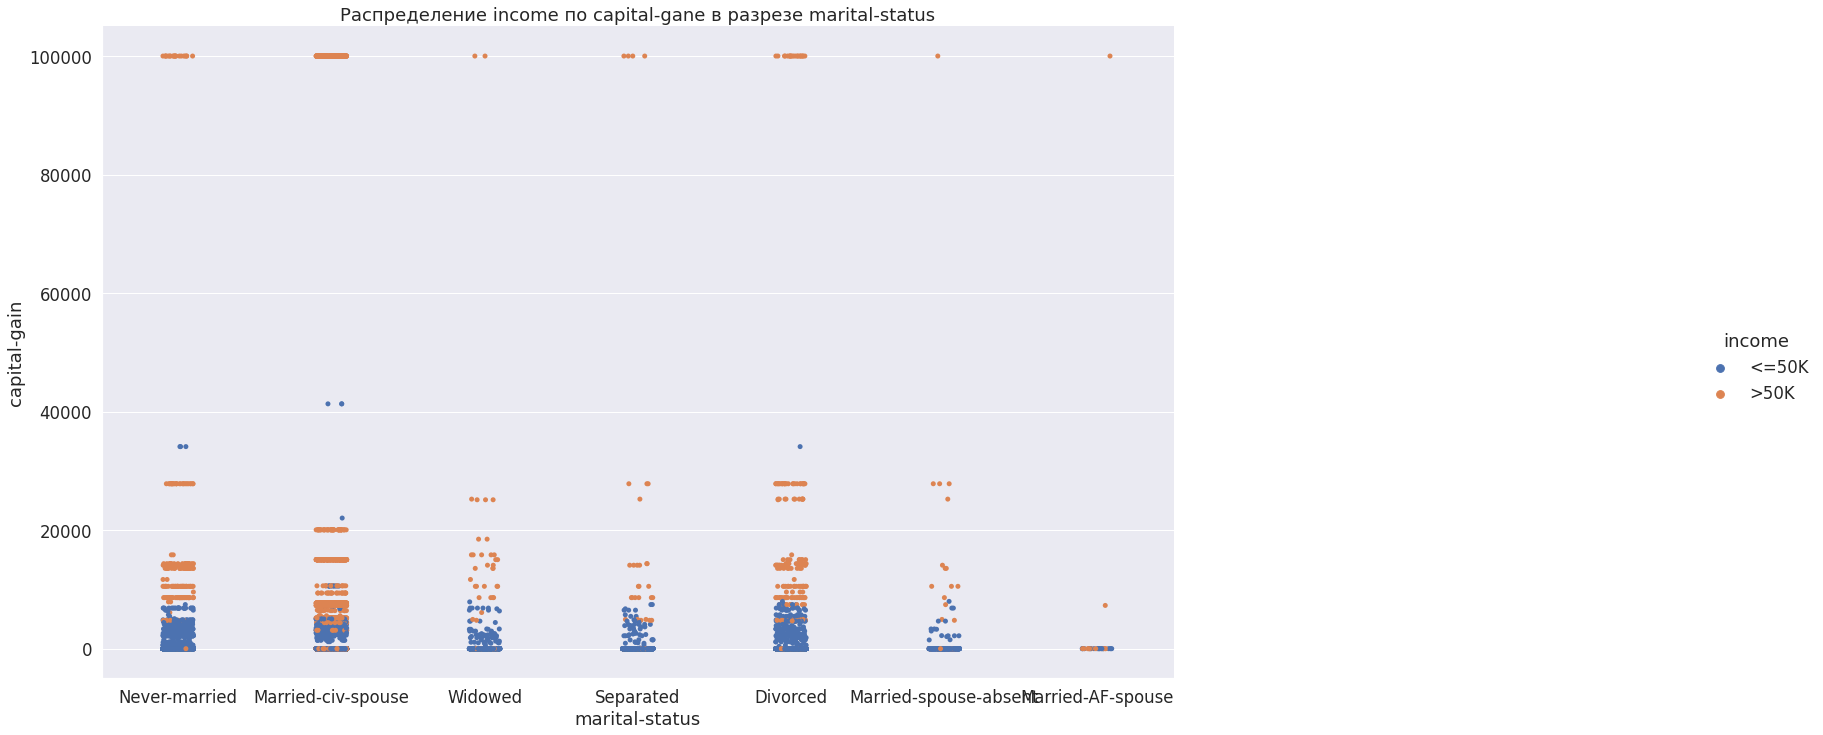

In [27]:
sns.set(font_scale = 1.5)
g = sns.catplot(x = 'marital-status',
                y = 'capital-gain',
                hue = 'income',
                data = adult).set(title=f'Распределение income по capital-gane в разрезе marital-status')

g.fig.set_figwidth(35)
g.fig.set_figheight(12)

In [28]:
adult['marital-status'].value_counts()

Married-civ-spouse       21055
Never-married            14598
Divorced                  6297
Separated                 1411
Widowed                   1277
Married-spouse-absent      552
Married-AF-spouse           32
Name: marital-status, dtype: int64

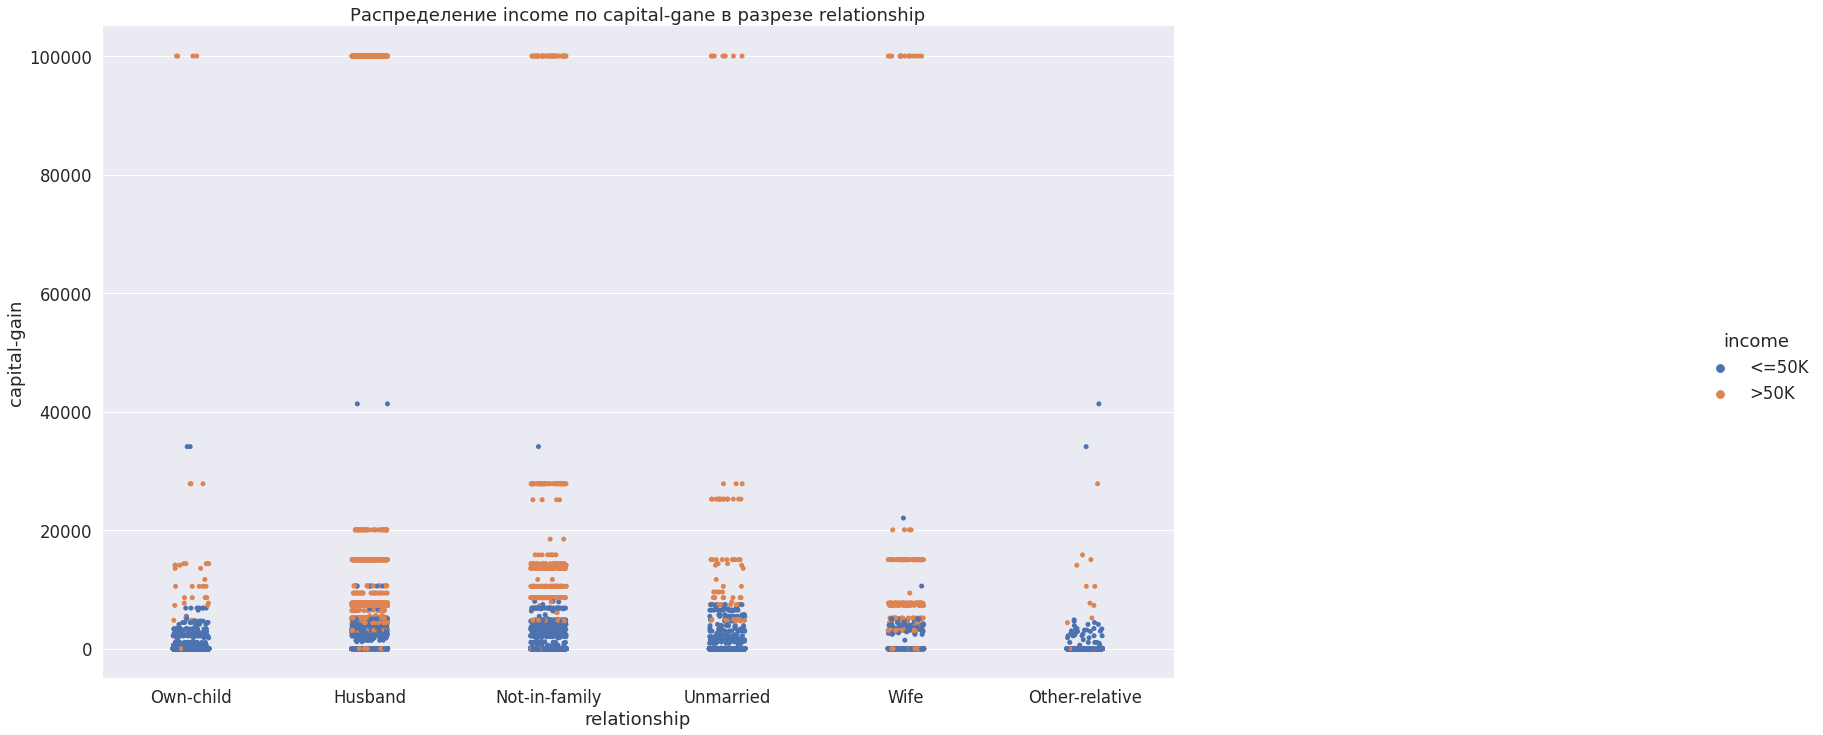

In [29]:
sns.set(font_scale = 1.5)
g = sns.catplot(x = 'relationship',
                y = 'capital-gain',
                hue = 'income',
                data = adult).set(title=f'Распределение income по capital-gane в разрезе relationship')

g.fig.set_figwidth(35)
g.fig.set_figheight(12)

In [30]:
adult['relationship'].value_counts()

Husband           18666
Not-in-family     11702
Own-child          6626
Unmarried          4788
Wife               2091
Other-relative     1349
Name: relationship, dtype: int64

**Логистическая регрессия**

Назначим предикторы. Преобразуем категориальные признаки в количественные:

In [92]:
X = pd.get_dummies(adult.loc[:, ['age','workclass','fnlwgt','education', 'educational-num','marital-status',
                                 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 
                                 'hours-per-week', 'native-country']])
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,34,198693,6,0,0,30,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


Преобразуем целевую переменную 'income' в 0 и 1

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [33]:
le.fit(adult['income'])

LabelEncoder()

In [34]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

In [35]:
le.transform( ['<=50K', '>50K', '<=50K'])

array([0, 1, 0])

In [36]:
y = pd.Series (data = le.transform(adult['income']))
y.head()

0    0
1    0
2    1
3    1
4    0
dtype: int64

Text(0.5, 1.0, 'Распределение по доходу')

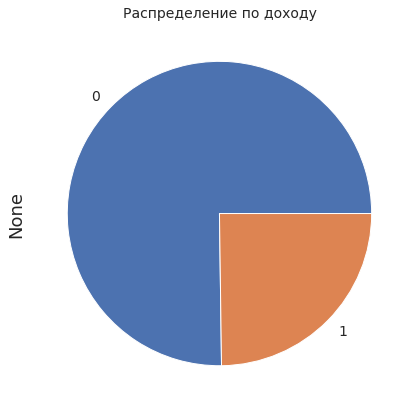

In [37]:
y.value_counts().plot(kind='pie', fontsize = 14)
plt.title('Распределение по доходу', fontsize = 14)

Данные распределны неравномерно, это надо будет учесть при делении выборки на тренировочную и тестовую

Стандартизируем признаки

In [81]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [82]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000000))

In [83]:
model = LogisticRegression(max_iter=1000000)

Поскольку данные распределены неравномерно, нам надо проконтролировать, чтобы тестовые и тренировочные значения были сбалансированы. Предположим, что пропорция значений в зависимой переменной соответствует реальной картине и нет надобности сэмплировать данные.

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True , stratify = y, test_size=0.2, random_state=42)

In [94]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [95]:
predictions

array([0, 0, 0, ..., 0, 1, 0])

In [96]:
model.predict_proba(X_test)

array([[0.73815164, 0.26184836],
       [0.71407708, 0.28592292],
       [0.64761572, 0.35238428],
       ...,
       [0.78538066, 0.21461934],
       [0.41368393, 0.58631607],
       [0.91840449, 0.08159551]])

Сравним

In [97]:
df_compare = pd.DataFrame ([y_test.values, predictions]).T
df_compare.columns = ['income', 'target']
df_compare

,income,target
0,0,0
1,1,0
2,0,0
3,1,0
4,0,0
...,...,...
9040,0,0
9041,1,0
9042,0,0
9043,1,1


In [98]:
model.score(X_train, y_train)

0.7913867927136026

In [99]:
model.score(X_test,y_test)

0.7917081260364842

На тестовых данных модель сработала чуточку лучше

**Метод опорных векторов (SVM)**

In [67]:
from sklearn.svm import SVC

In [68]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) 
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [55]:
clf.score(X_train, y_train) 

0.8538574232247008

In [56]:
clf.score(X_test, y_test)

0.8386954118297402

Эта модель сработала чуть лучше на тренировочных данных и чуть хуже на тестовых данных.



Попробуем убрать некоторые признаки, например fnlwgt, marital-status и workclass

In [100]:
X = pd.get_dummies(adult.loc[:, ['age','education', 'educational-num',
                                 'occupation', 'relationship', 'race', 
                                 'gender', 'capital-gain', 'capital-loss', 
                                 'hours-per-week', 'native-country']])
X.head()

,age,educational-num,capital-gain,capital-loss,hours-per-week,education_10th,education_11th,education_12th,education_1st-4th,education_5th-6th,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,7,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,9,0,0,50,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,12,0,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,44,10,7688,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,34,6,0,0,30,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


lr

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True , stratify = y, test_size=0.2, random_state=42)

In [102]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [103]:
model.score(X_train, y_train)

0.8468640296320867

In [104]:
model.score(X_test,y_test)

0.8416804864566059

С этим набором признаков модель логистической регрессии сработала лучше

SVM

In [72]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [73]:
clf.score(X_train, y_train) 

0.8538574232247008

In [74]:
clf.score(X_test, y_test)

0.8386954118297402

У SVM результат такой же, как и со всеми признаками.

**Факультативная часть**

В поисках статей по исследованию данных перед постороением моделей, наткнулась на эту https://habr.com/ru/post/550978/, где используется тот же датасет и приводится пример того, как можно отобрать количественные признаки для построения модели. Попробуем.

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer

In [106]:
# оставим только численые признаки
X_num = adult.select_dtypes(exclude=['object']).copy()


X_num.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,25,226802,7,0,0,40
1,38,89814,9,0,0,50
2,28,336951,12,0,0,40
3,44,160323,10,7688,0,40
5,34,198693,6,0,0,30


In [107]:
# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', figsize=(12,7), 
                                               legend=False, fontsize = 14))
        plt.title('Cтепень влияния количественных признаков для lr', fontsize = 14)

    else:
        raise KeyError('Unknown model_type')
        

In [108]:
def grid_search(model, gs_params):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, verbose=0)
    gs.fit(X_num, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs

Посмотрим точность на кросс-валидации и важность признаков для линейной модели (с L1-регуляризацией). Для нормализации данных будем использовать метод PowerTransformer.

scores = [0.81700185 0.82057412 0.81501074 0.82655511 0.83376085] 
mean score = 0.82258 +/- 0.00683


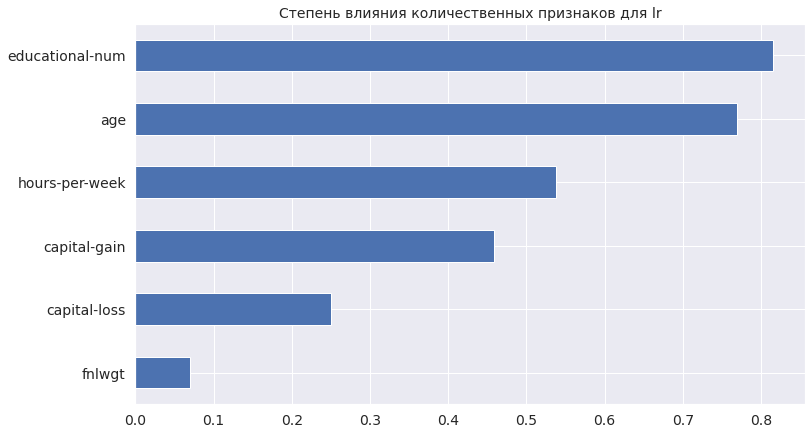

In [109]:
lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',                                       
                                         class_weight='balanced',
                                         random_state=SEED)
               )])
scores = cross_val_score(estimator=lr, X=X_num, y=y, 
                         scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=X_num, target=y, column_names=X_num.columns, model_type='lr')

Интересно, что визуальное исследование парметров не совпадает с этими результатами. Посмотрим, как будет вести себя модель.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y, shuffle = True , stratify = y, test_size=0.2, random_state=42)

In [111]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [112]:
model.score(X_train, y_train)

0.7913038670978799

In [113]:
model.score(X_test,y_test)

0.7919292426755113

Оценка на тестовых данных стала чуточку выше, но разница не очень заметная.